In [64]:
import os
import glob
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import trendy_functions as trendy

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [2]:
cluster = PBSCluster(
    cores=1,
    memory='40GB',
    processes=1,
    queue='casper',
    resource_spec='select=1:ncpus=1:mem=25GB',
    account='P93300041',
    walltime='06:00:00',
    log_directory="/glade/derecho/scratch/afoster/dask_logs/",
    local_directory='/glade/work/afoster',
)

In [3]:
print("Creating cluster... ", end="")

cluster.scale(100)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Creating cluster... 

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.200:35989,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## TRENDY output

This script assumes you have already generated the globally gridded files requested by TRENDY.

In [40]:
def get_all_vars(output_dir, variable, exps=['S0', 'S1', 'S2', 'S3']):

    exp_ds = []
    for exp in exps:
        exp_ds.append(xr.open_dataset(os.path.join(output_dir, exp,
                                                   f'CLM6.0_{exp}_{variable}.nc')))
    ds_all = xr.concat(exp_ds, dim="experiment", data_vars="all")
    ds_all = ds_all.assign_coords(experiment=("experiment", exps))

    return ds_all

def get_both_years(output_dir_2024, output_dir_2025, variable, exps=['S0', 'S1', 'S2', 'S3']):
    ds2024 = get_all_vars(output_dir_2024, variable, exps=exps)
    ds2025 = get_all_vars(output_dir_2025, variable, exps=exps)
    ds_both = xr.concat([ds2024, ds2025], dim="version", data_vars="all")
    ds_both = ds_both.assign_coords(version=("version", ["2024", "2025"]))
    return ds_both

def get_variable_data(variable, var_df, output_dir_2024, output_dir_2025, cf):
    
    ds = get_both_years(output_dir_2024, output_dir_2025, variable, exps=['S3'])
    ds = ds.isel(experiment=0)

    var_info = var_df[var_df.output_varname == variable]
    if var_info.frequency.values[0] == 'monthly':
        da = trendy.calculate_annual_mean(ds[variable])
    else:
        da = ds[variable]

    da_glob = trendy.calculate_global_sum(da, land_area_global)*cf

    return da, da_glob

def plot_rolling_mean(rolling_mn, ylabel, units, yrs=10):
    trendy.get_blank_plot()
    plt.xlim([1901, 2024])
    plt.ylim(-2, 6)
    plt.grid(True, which="both", axis="y", linestyle="--", linewidth=0.5, color="black", alpha=0.3)
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    for version in versions:
        subset = rolling_mn.sel(version=version)
        plt.plot(subset.year, subset, label=version)
    plt.axhline(y=0.1, color="gray", linestyle=":")
    plt.axhline(y=-0.1, color="gray", linestyle=":")
    plt.xlabel("Year")
    plt.ylabel(f"{ylabel} {yrs}-yr running mean {units}")
    plt.legend(loc="upper left")

def plot_cumsum_NBP(da_glob):
    trendy.get_blank_plot()
    plt.xlim([1700, 2024])
    plt.ylim(-200, 200)
    plt.grid(True, which="both", axis="y", linestyle="--", linewidth=0.5, color="black", alpha=0.3)
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    for version in versions:
        subset = da_glob.sel(version=version)
        plt.plot(subset.year, subset.cumsum(), label=version)
    plt.axhline(y=0.1, color="gray", linestyle=":")
    plt.axhline(y=-0.1, color="gray", linestyle=":")
    plt.xlabel("Year")
    plt.ylabel("NBP Cumulative Sum (PgC yr$^{-1}$)")
    plt.legend(loc="upper left")
    plt.savefig('NBP_2024_2025_compare.png')

In [22]:
# output directory
campaign_dir = "/glade/campaign/cgd/tss/projects"
output_dir_2025 = os.path.join(campaign_dir, 'TRENDY2025', 'outputs')
output_dir_2024 = os.path.join(campaign_dir, 'TRENDY2024', 'to_trendy')

# experiment suffixes
exps = ['S0', 'S1', 'S2', 'S3']

versions = ['2024', '2025']

# information about postprocessing
var_df_file = '/glade/work/afoster/TRENDY/trendyclm/data/trendy_listofvariables_CLM_2025.csv'
var_df = pd.read_csv(var_df_file)
output_vars = var_df.output_varname.unique()

In [7]:
# land fraction and land area information
grid_area_file = os.path.join(output_dir_2025, "S3", "CLM6.0_S3_gridArea.nc")
ocean_frac_file = os.path.join(output_dir_2025, "S3", "CLM6.0_S3_oceanCoverFrac.nc")
grid_area = xr.open_dataset(grid_area_file)
ocean_frac = xr.open_dataset(ocean_frac_file)
land_frac = 1.0 - ocean_frac.oceanCoverFrac
land_area_global = grid_area.gridArea * land_frac

In [9]:
cf_land = 1 / land_area_global.sum(dim=["lat", "lon"]).values
cf_PgC = 1e-12 * 24 * 60 * 60 * 365
cf_PgC_notime = 1e-12

In [75]:
var_df[var_df.output_varname == 'cVeg']

,CLM_run,CLM_varname,output_varname,long_name,CMOR_dims,priority,NA_val,frequency,output_function,CLM_units,conversion_factor,global_cf,dimension,units
11,1,TOTVEGC,cVeg,Carbon in Vegetation,longitude latitude time,1,-99999,annual,sum,gC/m2,0.001,1.000000e-15,global,kg m-2


In [78]:
cf_dict = {
    "nbp": cf_PgC,
    "gpp": cf_PgC,
    "cVeg": 1.0,
}

In [79]:
variable = 'cVeg'
da, da_glob = get_variable_data(variable, var_df, output_dir_2024,
                                output_dir_2025, cf_dict[variable])

In [87]:
da_slice = da.isel(time=slice(300, 324)).mean(dim='time')

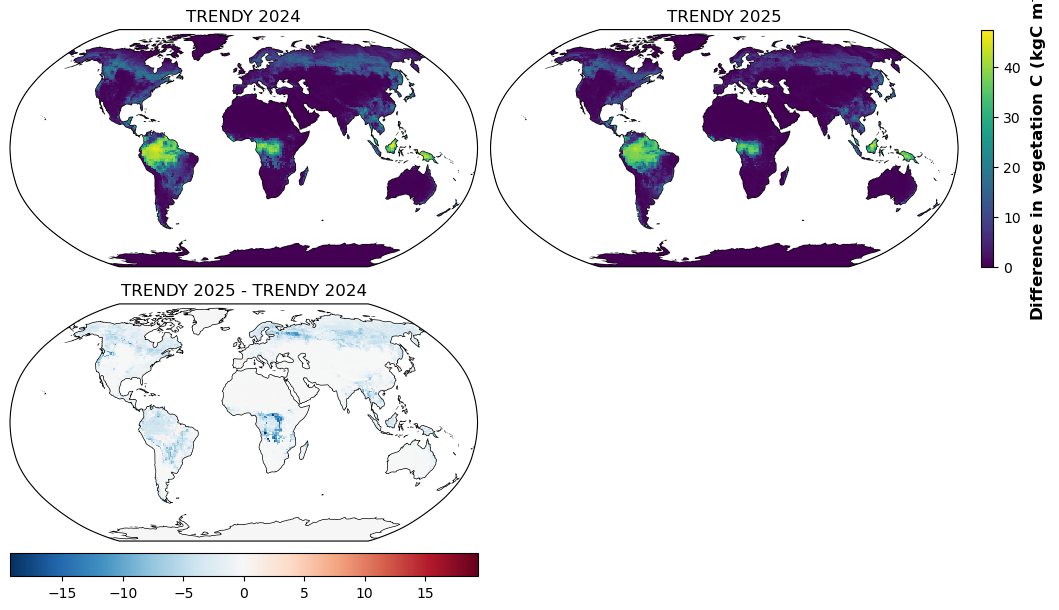

In [88]:
figure, ax = plt.subplots(2, 2, figsize=(13, 6),
                            subplot_kw=dict(projection=ccrs.Robinson()),
                            layout="compressed")
axes = ax.flatten(order="F")
for i, ax in enumerate(axes):
    
    ax.coastlines()
    ax.add_feature(
        cfeature.NaturalEarthFeature("physical", "ocean", "110m", facecolor="white")
    )
    if i == 0:
        pcm = ax.pcolormesh(
            da_slice.lon,
            da_slice.lat,
            da_slice.isel(version=0),
            transform=ccrs.PlateCarree(),
            shading="auto",
            cmap='viridis',
            vmin=0.0,
            vmax=np.max(da_slice),
        )
        ax.set_title('TRENDY 2024')
    if i == 2:
        pcm = ax.pcolormesh(
            da_slice.lon,
            da_slice.lat,
            da_slice.isel(version=1),
            transform=ccrs.PlateCarree(),
            cmap='viridis',
            vmin=0.0,
            vmax=np.max(da_slice),
        )
        ax.set_title('TRENDY 2025')
    if i == 1:
        diff = da_slice.isel(version=1) - da_slice.isel(version=0)
        pcmdiff = ax.pcolormesh(
            da_slice.lon,
            da_slice.lat,
            diff,
            transform=ccrs.PlateCarree(),
            shading="auto",
            cmap='RdBu_r',
            vmin=-1.0*np.max(np.abs(diff)),
            vmax=np.max(np.abs(diff))
        )
        ax.set_title('TRENDY 2025 - TRENDY 2024')

figure.delaxes(axes[3])
cbar1 = figure.colorbar(pcm, ax=axes[2], shrink=1, orientation="vertical")
cbar2 = figure.colorbar(pcmdiff, ax=axes[1], shrink=1, orientation="horizontal")
cbar1.set_label("Vegetation C (kgC m$^{-2}$)", size=12, fontweight="bold")
cbar1.set_label("Difference in vegetation C (kgC m$^{-2}$)", size=12, fontweight="bold")
plt.savefig('biomass_diff.png')